Computing Transitions: 100%|██████████| 26136/26136 [00:02<00:00, 10077.58it/s]


Iter 1 | Delta = 2.191600 | Progress: 0.00%
Iter 2 | Delta = 1.740210 | Progress: 0.00%
Iter 3 | Delta = 1.540239 | Progress: 0.00%
Iter 4 | Delta = 1.332612 | Progress: 0.00%
Iter 5 | Delta = 1.114457 | Progress: 0.00%
Iter 6 | Delta = 0.908552 | Progress: 9.14%
Iter 7 | Delta = 0.695975 | Progress: 30.40%
Iter 8 | Delta = 0.485737 | Progress: 51.43%
Iter 9 | Delta = 0.430467 | Progress: 56.95%
Iter 10 | Delta = 0.387420 | Progress: 61.26%
Iter 11 | Delta = 0.348678 | Progress: 65.13%
Iter 12 | Delta = 0.313811 | Progress: 68.62%
Iter 13 | Delta = 0.282430 | Progress: 71.76%
Iter 14 | Delta = 0.254187 | Progress: 74.58%
Iter 15 | Delta = 0.228768 | Progress: 77.12%
Iter 16 | Delta = 0.205891 | Progress: 79.41%
Iter 17 | Delta = 0.185302 | Progress: 81.47%
Iter 18 | Delta = 0.166772 | Progress: 83.32%
Iter 19 | Delta = 0.150095 | Progress: 84.99%
Iter 20 | Delta = 0.135085 | Progress: 86.49%
Iter 21 | Delta = 0.118192 | Progress: 88.18%
Iter 22 | Delta = 0.055507 | Progress: 94.45%
Ite

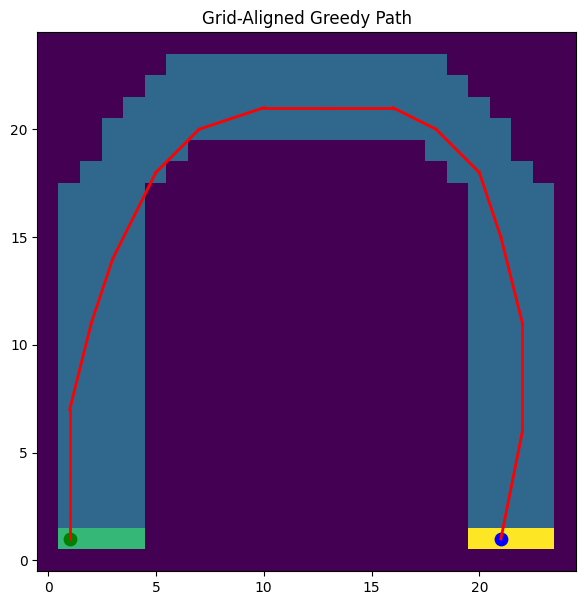

In [ ]:
from typing import List,Tuple,TypeAlias,Set, Dict
from enum import Enum, auto
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Parameters: This line is a must. The grader parser uses this line to locate the Parameters cell.
GROUP_ID = 29
ALGORITHM = 'ValItr'  # ValItr | QLrng | SARSA. Note that “|” denotes a choice. Only one of the choices should be provided.
TRACK_NAME = 'tracks/U-track.txt'
CRASH_POS = 'NRST' # NRST | STRT


FAIL_RATE = 0.2
START_IDX = 0

# region Definitions and Setup
Square: TypeAlias = Tuple[int, int]
Vector: TypeAlias = Tuple[int, int]

class SquareType(Enum):
    START = auto()       # starting square ('S')
    FINISH = auto()      # finish square ('F')
    OPEN = auto()        # open path ('.')
    WALL = auto()        # wall ('#')
    
    def __str__(self):
        return self.name

CHAR_TO_TOK = {
    'S':SquareType.START,
    'F':SquareType.FINISH,
    '.':SquareType.OPEN,
    '#':SquareType.WALL
}

TOK_TO_CHAR = {k:v for v,k in CHAR_TO_TOK.items()}

SQUARE_COST = {
    SquareType.START: 1,
    SquareType.OPEN: 1,
    SquareType.FINISH: 0,
    SquareType.WALL: None
}
# endregion

# region Track and Environment Classes
class Track:
    def __init__(self,filename=TRACK_NAME):
        self.state: List[List[SquareType]] = []
        self.start_squares: List[Square] = []
        self.finish_squares: List[Square] = []

        self.parse_track(filename)

    def __str__(self):
        out = ""
        for row in self.state:
            out += ''.join([TOK_TO_CHAR[tok] for tok in row])
            out += '\n'
        return out[:-1]

    def parse_track(self,track):
        with open(track, 'r') as f:
            lines = f.readlines()
            for row,line in enumerate(lines[1:]):
                tok_line = []
                for col,char in enumerate(line):
                    if char=='\n': continue
                    
                    tok = CHAR_TO_TOK[char]
                    if tok == SquareType.START: self.start_squares.append((row,col))
                    if tok == SquareType.FINISH: self.finish_squares.append((row,col))
                    
                    tok_line.append(tok)
                
                self.state.append(tok_line)

    def get_square(self,square: Square) -> SquareType:
        return self.state[square[0]][square[1]]

    def get_drivable_squares(self) -> List[Square]:
        """
        Returns all squares that are not walls
        """
        return [
            (r, c)
            for r, row in enumerate(self.state)
            for c, col in enumerate(row)
            if col != SquareType.WALL
        ]

    def get_start_squares(self) -> List[Square]:
        return self.start_squares

    def is_square_finish(self, square: Square) -> bool:
        return self.get_square(square) == SquareType.FINISH


    def is_square_drivable(self,square: Square) -> bool:
        r, c = square
        if r < 0 or r >= len(self.state):
            return False
        if c < 0 or c >= len(self.state[0]):
            return False
        return self.get_square(square) != SquareType.WALL

class RaceTrackEnv:
    def __init__(self, track: None|Track = None,starting_square: Square = None):
        self.track:        Track = track or Track()
        self.position:     Square = starting_square or self.track.start_squares[START_IDX]
        self.velocity:     Vector = (0,0)
        self.acceleration: Vector = (0,0)

    def stop(self):
        self.acceleration = self.velocity = (0,0)

    def reset(self, position: Square):
        self.stop()
        self.position = position

    @staticmethod
    def cap_velocity(velocity: Vector) -> Vector:
        return tuple(min(5,max(-5,val)) for val in velocity)

    @staticmethod
    def bresenham_line(pos1: Square, pos2: Square) -> List[Square]:
        """Generate all points along a line using Bresenham's algorithm"""

        points = []

        x0, y0 = pos1
        x1, y1 = pos2
        dx, dy = abs(x1 - x0), abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        x, y = x0, y0
        while True:
            points.append((x, y))
            if x == x1 and y == y1:
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x += sx
            if e2 < dx:
                err += dx
                y += sy

        return points

    def do_crash(self,position: Square,crash_position: str):
        """
        Handles the crash based on the crash_position policy.
        crash_position: 'NRST' | 'STRT'
        1. 'NRST': Move to the nearest square.
        2. 'STRT': Move to the starting square used at the beginning of the race
        """
        if crash_position == 'NRST':
            nearest_start = min(self.track.get_drivable_squares(), key=lambda sq: (sq[0]-position[0])**2 + (sq[1]-position[1])**2)
            self.reset(nearest_start)
        elif crash_position == 'STRT':
            self.reset(self.track.start_squares[START_IDX])
        else:
            raise ValueError(f"Invalid crash_position policy: {crash_position}")

    def check_crash(self,target_square: Square) -> Square|None:
        """
        Check if moving along a line from current position to target crashes into an obstacle.
        Uses Bresenham's line algorithm to trace the path.
        """

        # Get all points along the path
        path_points = self.bresenham_line(
            self.position, target_square
        )
        # Check each point for collision
        for sq in path_points:
            if not self.track.is_square_drivable(sq):
                return sq  # Crash detected
        return None  # No crash

    @staticmethod
    def check_failure(fail_rate: float) -> bool:
        """
        Returns True if the action fails based on the fail_rate.
        """
        if random.random() < fail_rate:
            return True
        return False
    
    def check_finish(self) -> bool:
        return self.track.is_square_finish(self.position)

    def step(self,acceleration: Vector,fail_rate=FAIL_RATE,crash_position=CRASH_POS):
        """
        Perform a step in the environment given an acceleration.
        `Note velocity values are capped to [-5,5]`
        acceleration: Tuple[int,int] where each value is in [-1,0,1]
        fail_rate: Probability of action failure.
        crash_position: 'NRST' | 'STRT' policy for handling crashes.
        Returns: None
        """
        if not all(a in [-1,0,1] for a in acceleration):
            raise ValueError(f"Invalid acceleration: {acceleration}")
        
        do_accel = True
        if self.check_failure(fail_rate): do_accel = False
        if do_accel:
            self.acceleration = acceleration
        
        self.velocity = self.cap_velocity((self.velocity[0]+self.acceleration[0],self.velocity[1]+self.acceleration[1]))
        target_position = (self.position[0]+self.velocity[0],self.position[1]+self.velocity[1])

        crash = self.check_crash(target_position)
        if not crash: self.position = target_position
        else: self.do_crash(crash,crash_position)


# endregion

# region Model Based
State: TypeAlias = Tuple[Square,Vector]

class MDPModel:
    """
    For use with ValueIterationAgent
    """
    def __init__(self, track: Track|None = None):
        # List / iterable of all states in the MDP
        self.track = track or Track()
        self.states: Set[State] = set([
            (square, (vx, vy))
            for square in self.track.get_drivable_squares()
            for vx in range(-5, 6)
            for vy in range(-5, 6)
        ])
        self.crash_cache: Dict[(Square,Square):Square] = {}
        self.transitions: Dict[(State, Vector):List[(State, float)]] = {
            (state,action):self.compute_transition_states_and_probs(state,action)
            for state in tqdm(self.states,desc="Computing Transitions")
            for action in self.get_possible_actions()
        }

        

    @staticmethod
    def cap_velocity(velocity: Vector) -> Vector:
        return tuple(min(5,max(-5,val)) for val in velocity)

    @staticmethod
    def bresenham_line(pos1: Square, pos2: Square) -> List[Square]:
        """Generate all points along a line using Bresenham's algorithm"""

        points = []

        x0, y0 = pos1
        x1, y1 = pos2
        dx, dy = abs(x1 - x0), abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        x, y = x0, y0
        while True:
            points.append((x, y))
            if x == x1 and y == y1:
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x += sx
            if e2 < dx:
                err += dx
                y += sy

        return points

    def check_crash(self, start_square: Square, target_square: Square) -> Square | None:
        """
        Check if moving along a line from start_square to target_square crashes into an obstacle.
        Uses Bresenham's line algorithm to trace the path.
        Returns the first crash square, or None if no crash.
        """
        path = (start_square, target_square)
        if path in self.crash_cache:
            return self.crash_cache[path]

        path_points = self.bresenham_line(start_square, target_square)

        crash_square = None
        for sq in path_points:
            if not self.track.is_square_drivable(sq):
                crash_square = sq
                break

        self.crash_cache[path] = crash_square
        return crash_square

    def do_crash(self, position: Square,crash_position: str):
        if crash_position == 'NRST':
            nearest_start = min(self.track.get_drivable_squares(), key=lambda sq: (sq[0]-position[0])**2 + (sq[1]-position[1])**2)
            return nearest_start
        elif crash_position == 'STRT':
            return self.track.start_squares[START_IDX]
        else:
            raise ValueError(f"Invalid crash_position policy: {crash_position}")

    @staticmethod
    def get_possible_actions() -> List[Vector]:
        """
        Actions are accelerations in this problem.
        :return: a list of possible actions (acceleration values).
        """
        return [(x,y) for x in [-1,0,1] for y in [-1,0,1]]

    def compute_transition_states_and_probs(self, state: State, action,crash_position=CRASH_POS) -> List[Tuple[State, float]]:
        """
        Return a list of (next_state, prob) pairs describing the transition
        model P(s' | s, a).
        """
        start_position,start_velocity = state

        success_velocity = self.cap_velocity((start_velocity[0]+action[0],start_velocity[1]+action[1]))
        success_position = (start_position[0]+success_velocity[0],start_position[1]+success_velocity[1])
        crash = self.check_crash(start_position, success_position)
        if crash:
            success_position = self.do_crash(crash,crash_position)
            success_velocity = (0,0)

        fail_velocity = self.cap_velocity(start_velocity)
        fail_position = (
            start_position[0] + fail_velocity[0],
            start_position[1] + fail_velocity[1],
        )
        crash = self.check_crash(start_position, fail_position)
        if crash:
            fail_position = self.do_crash(crash, crash_position)
            fail_velocity = (0, 0)


        return ([
            ((fail_position,fail_velocity),FAIL_RATE),
            ((success_position,success_velocity),1-FAIL_RATE)
        ])

    def get_transition_states_and_probs(self,state:State, action:Vector):
        return self.transitions[(state,action)]

    def get_cost(self, next_state):
        """
        Return the immediate cost
        """
        return SQUARE_COST[self.track.get_square(next_state[0])]


class ValueIterationAgent:
    """
    Classic value-iteration planner:
    After convergence we extract a greedy policy.
    """
    def __init__(self, model: MDPModel | None = None,
                 gamma: float = 0.9,
                 theta: float = 1e-3):
        # Value function: dict[state] -> float
        self.value_table: dict = {}
        # Deterministic greedy policy: dict[state] -> action
        self.policy: dict = {}

        self.model: MDPModel | None = model
        self.gamma: float = gamma
        self.theta: float = theta  # convergence threshold

        # If a model is already provided and has states, initialize and run VI
        if self.model is not None and hasattr(self.model, "states"):
            for s in self.model.states:
                self.value_table[s] = 0.0
            self.value_iteration()

    def value_iteration(self):
        assert self.model is not None, "ValueIterationAgent: model is not set."

        for s in getattr(self.model, "states", []):
            self.value_table.setdefault(s, 0.0)

        i = 0
        initial_delta = None
        while True:
            delta = 0.0
            i+=1
            for s in self.model.states:
                pos, vel = s
                # Treat finish as terminal: value stays at 0
                if self.model.track.is_square_finish(pos):
                    new_v = 0.0
                else:
                    actions = self.model.get_possible_actions()
                    if not actions:
                        new_v = 0.0
                    else:
                        best_q = float("-inf")
                        for a in actions:
                            q = 0.0
                            for next_state, prob in self.model.get_transition_states_and_probs(s, a):
                                r = -self.model.get_cost(next_state)
                                q += prob * (r + self.gamma * self.value_table.get(next_state, 0.0))
                            if q > best_q:
                                best_q = q
                        new_v = best_q

                delta = max(delta, abs(new_v - self.value_table.get(s, 0.0)))
                self.value_table[s] = new_v
                if initial_delta is None:
                    initial_delta = delta
                
            progress = 1 - (delta / initial_delta)
            progress = max(0, min(progress, 1))  # clamp for safety

            print(f"Iter {i} | Delta = {delta:.6f} | Progress: {progress*100:.2f}%")

            if delta < self.theta:
                break
        
        self._extract_policy()


    def _extract_policy(self):
        assert self.model is not None, "ValueIterationAgent: model is not set."

        self.policy.clear()
        for s in self.model.states:
            pos, vel = s
            if self.model.track.is_square_finish(pos):
                continue  # terminal, no action

            actions = self.model.get_possible_actions()
            if not actions:
                continue

            best_a = None
            best_q = float("-inf")
            for a in actions:
                q = 0.0
                for next_state, prob in self.model.get_transition_states_and_probs(s, a):
                    r = self.model.get_cost(next_state)
                    q += prob * (r + self.gamma * self.value_table.get(next_state, 0.0))
                if q > best_q:
                    best_q = q
                    best_a = a

            self.policy[s] = best_a


    def get_action_for(self, state):
        """
        Return the greedy action for `state` according to the current policy.
        If the state is unknown, fall back to a simple default (None).
        """
        # If we don't have an explicit policy entry, we can either:
        #  - return None
        #  - or compute a one-step greedy action on the fly
        if state in self.policy:
            return self.policy[state]

        if self.model is None:
            return None

        actions = self.model.get_possible_actions()
        if not actions:
            return None

        # One-step greedy backup for unseen states
        best_a = None
        best_q = float("-inf")
        for a in actions:
            q = 0.0
            for next_state, prob in self.model.get_transition_states_and_probs(state, a):
                r = -self.model.get_cost(next_state)
                q += prob * (r + self.gamma * self.value_table.get(next_state, 0.0))
            if q > best_q:
                best_q = q
                best_a = a

        return best_a

    def extract_greedy_path(self, max_steps: int = 1000) -> List[Square]:
        """
        Roll out the greedy policy from the first start square.
        Returns a list of positions (Squares).
        """
        assert self.model is not None

        start_square = self.model.track.start_squares[START_IDX]
        state: State = (start_square, (0, 0))

        path: List[Square] = [start_square]

        for t in range(max_steps):
            pos, vel = state

            # Stop if finish
            if self.model.track.is_square_finish(pos):
                break

            action = self.get_action_for(state)

            # Deterministic greedy next state
            transitions = self.model.get_transition_states_and_probs(state, action)
            next_state, _ = max(transitions, key=lambda item: item[1])

            state = next_state
            path.append(state[0])

        return path


    def stochastic_greedy_path(self, max_steps: int = 1000) -> List[Square]:
        """
        Roll out the greedy policy from start_square
        """

        state: State = (self.model.track.get_start_squares()[START_IDX], (0, 0))
        path: List[Square] = [start_square]

        for t in range(max_steps):
            pos, vel = state

            # Stop if finish
            if self.model.track.is_square_finish(pos):
                break


            action = self.get_action_for(state)
            transitions = self.model.get_transition_states_and_probs(state, action)
            next_state,_ = transitions[0] if random.random() < transitions[0][1] else transitions[1]

            state = next_state
            path.append(state[0]) 
        return path
# endregion


# region Model Free
class SARSAAgent:
    def __init__(self):
        qtable = {}
        alpha = 0
        gamma = 0
        epsilon = 0
        last_state = None
        last_action = None

    def act(self,state):
        pass

    def update(self,state,action,reward,next_state,next_action):
        pass

    def best_action(self,state):
        pass

class QLearningAgent:
    def __init__(self):
        qtable = {}
        alpha = 0
        gamma = 0
        epsilon = 0

    def act(self,state):
        pass

    def update(self,state,action,reward,next_state):
        pass

    def best_action(self,state):
        pass
# endregion

# region Output and Metrics
class EpisodeRunner:
    def __init__(self):
        env = None
        agent = None
        max_steps = 0

    def run_episode(self,algorithm: SARSAAgent|QLearningAgent):
        pass



class MetricsLogger:
    def __init__(self):
        self.episodes: List[int] = []
        self.steps: List[int] = []
        self.rewards: List[float] = []

    def log_episode(self, episode: int, steps: int, reward: float):
        """
        Store metrics for a single episode.
        """
        self.episodes.append(episode)
        self.steps.append(steps)
        self.rewards.append(reward)

    def print_metrics(self):
        """
        Print simple summary statistics over episodes.
        """
        if not self.episodes:
            print("No episodes logged.")
            return

        n = len(self.episodes)
        avg_steps = sum(self.steps) / n
        avg_reward = sum(self.rewards) / n

        print(f"Episodes logged: {n}")
        print(f"Steps per episode: mean = {avg_steps:.2f}, "
              f"min = {min(self.steps)}, max = {max(self.steps)}")
        print(f"Reward per episode: mean = {avg_reward:.2f}, "
              f"min = {min(self.rewards):.2f}, max = {max(self.rewards):.2f}")

    def plot_path(self, track: Track, path: List[Square]):
        import matplotlib.pyplot as plt
        import numpy as np

        n_rows = len(track.state)
        n_cols = len(track.state[0])

        # Build grid image
        grid = np.zeros((n_rows, n_cols))
        for r, row in enumerate(track.state):
            for c, cell in enumerate(row):
                if cell == SquareType.WALL:
                    grid[r, c] = 0
                elif cell == SquareType.OPEN:
                    grid[r, c] = 1
                elif cell == SquareType.START:
                    grid[r, c] = 2
                elif cell == SquareType.FINISH:
                    grid[r, c] = 3

        plt.figure(figsize=(7, 7))
        plt.imshow(grid, origin="upper")

        # Draw each step separately to avoid diagonal corner-cutting visuals
        for (r1, c1), (r2, c2) in zip(path[:-1], path[1:]):
            plt.plot([c1, c2], [r1, r2], color="red", linewidth=2)

        # Mark start and end
        (sr, sc) = path[0]
        (er, ec) = path[-1]
        plt.scatter([sc], [sr], s=80, color="green")   # start
        plt.scatter([ec], [er], s=80, color="blue")    # end

        plt.gca().invert_yaxis()
        plt.title("Grid-Aligned Greedy Path")
        plt.show()


# endregion

def main():
    track = Track(TRACK_NAME)
    model = MDPModel(track)
    agent = ValueIterationAgent(model=model, gamma=0.9, theta=1e-3)

    logger = MetricsLogger()

    # (If you later run episodes with model-free methods, you'd call log_episode there.)
    # For VI, just visualize the greedy path once:

    start_square = track.start_squares[START_IDX]
    best_path = agent.extract_greedy_path()

    logger.plot_path(track, best_path)


if __name__ == "__main__":
    main()






